In [7]:
# Import necessary libraries and modules
import os
import pandas as pd
import numpy as np

pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.options.display.float_format = '{:.2f}'.format

from datetime import date, timedelta

# Import the ticker data extraction method
from data.yf_data_extract import yf_ticker_data_extraction
from data.polygon_data_extract import *

# Import the optimized strategy (assumed to be defined in strategies/optimized_strategy.py)
from strategies.base_strategy import BaseStrategy
from strategies.optimized_strategy import OptimizedStrategy
from strategies.buy_and_hold_strategy import BuyAndHoldStrategy
from strategies.sentiment_strategy import SentimentStrategy
from strategies.ml_regression_strategy import MLRegressionStrategy

# Import the backtest runner
from backtesting.backtest_runner import BacktestRunner

#ml models
from ml.base_model import ModelHandler
from ml.preprocessor import PreprocessingService
from ml.model_xgb import XGBoostModelHandler
from ml.normal_transformer import NormalTransformer

from ml.model_result import Result, PipelineData
#from ml.model_result.model_eval import ModelEvaluation

from ml.ml_results.shapley_visualization import ShapleyVisualization


In [8]:
try:
    from config.config import POLYGON_API_KEY
except ImportError:
    print("Error: config.py not found or POLYGON_API_KEY not set.")
    print("Please create config.py and add your Polygon API key.")
    POLYGON_API_KEY = None # Or raise an error

API_KEY = POLYGON_API_KEY

In [9]:
# Define parameters for data extraction
ticker = "TSLA"  # You can change this ticker as needed
start_date = "2022-01-01"
end_date = date.today().strftime("%Y-%m-%d")
limit = 500
order = 'desc'

# Call the ticker_data_extraction method to download data from yfinance
stock_data = yf_ticker_data_extraction(ticker, start_date, end_date)
#news_data = fetch_polygon_news_df(API_KEY, ticker, start_date, end_date, limit, order)
#news_data = process_news_data(news_data, ticker)
# Display the first few rows of the extracted data


"""stock_data = stock_data.merge(news_data, how='inner'
                              ,left_on='date'
                              ,right_on='date')"""
#stock_data.set_index('date', inplace=True)
#stock_data.rename(columns=)
#stock_data = stock_data.drop('date_join', axis=1)
stock_data

[*********************100%***********************]  1 of 1 completed

,open,high,low,close,volume
date,,,,,
2022-01-03,382.58,400.36,378.68,399.93,103931400
2022-01-04,396.52,402.67,374.35,383.20,100248300
2022-01-05,382.22,390.11,360.34,362.71,80119800
2022-01-06,359.00,362.67,340.17,354.90,90336600
2022-01-07,360.12,360.31,336.67,342.32,84164700
...,...,...,...,...,...
2025-05-23,337.92,343.18,333.21,339.34,84654800
2025-05-27,347.35,363.79,347.32,362.89,120146400
2025-05-28,364.84,365.00,355.91,356.90,91404300


In [10]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 855 entries, 2022-01-03 to 2025-05-30
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   open    855 non-null    float64
 1   high    855 non-null    float64
 2   low     855 non-null    float64
 3   close   855 non-null    float64
 4   volume  855 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 40.1 KB


In [11]:
#model
train_start_date = "2021-01-01"
train_end_date = "2025-01-01"
prediction_start_date = "2025-01-01"
prediction_end_date = end_date
lag_columns = ['close', 'volume']
feature_groups = {
        "ma": True,
        "ema": True,
        "rsi": True,
        "macd": True,
        "bollinger": True,
        "atr": True,
        "volatility": True,
        "momentum": True
    }

#call transformer
transformer = NormalTransformer(stock_data, lags=3, target_type="regression", feature_groups=feature_groups,lag_columns=lag_columns)
transformer.transform(stock_data)

training_dataset = transformer.create_dataset(
    start_date=train_start_date,
    end_date=train_end_date)

# prepare training set
columns_exclude = ['open','high','low','close','volume','negative','neutral','positive', 'price_change','target']
X, y = transformer.prepare_dataset(
    training_dataset=training_dataset,
    columns_exclude=columns_exclude,
    target_column='price_change',
    sort_col=None)

# create train test split
X_train, X_test, y_train, y_test = transformer.create_train_test_split(
    X, y, shuffle=False)

prediction_dataset = transformer.create_dataset(
    start_date=prediction_start_date,
    end_date=prediction_end_date)

# prepare training set
X_pred, y_pred = transformer.prepare_dataset(
    training_dataset=prediction_dataset,
    columns_exclude=columns_exclude,
    target_column='price_change')

INFO [2025-06-02 16:50:59,039] (normal_transformer.py:transform): Transforming data...
INFO [2025-06-02 16:50:59,040] (normal_transformer.py:transform): Data transformation complete. Took 0.0 s.
INFO [2025-06-02 16:50:59,042] (normal_transformer.py:create_dataset): Creating dataset from 2021-01-01 to 2025-01-01.
INFO [2025-06-02 16:50:59,085] (base_transformer.py:data_type_handler): Data types adjusted.
INFO [2025-06-02 16:50:59,088] (normal_transformer.py:create_dataset): Dataset created with shape (702, 27).
INFO [2025-06-02 16:50:59,093] (normal_transformer.py:create_dataset): Creating dataset from 2025-01-01 to 2025-06-02.
INFO [2025-06-02 16:50:59,119] (base_transformer.py:data_type_handler): Data types adjusted.
INFO [2025-06-02 16:50:59,120] (normal_transformer.py:create_dataset): Dataset created with shape (51, 27).
WARNING [2025-06-02 16:50:59,123] (base_transformer.py:prepare_dataset): No sort column `ResponseTimestamp` found in dataset. Sorting will be skipped. Beware that `

In [12]:
prediction_dataset

,open,high,low,close,volume,price_change,target,close_lag_1,close_lag_2,close_lag_3,volume_lag_1,volume_lag_2,volume_lag_3,sma_20,sma_50,ema_20,ema_50,rsi_14,ema12,ema26,macd,macd_signal,bollinger_top,bollinger_bot,atr_14,volatility_14,roc_10
date,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-03-18,228.16,230.10,222.28,225.31,111477600,0.05,0.05,238.01,249.98,240.68,111900600.00,100242300.00,114813500.00,284.87,348.30,279.48,323.88,31.11,259.51,292.11,-33.02,-30.40,371.22,198.51,20.09,0.06,-0.16
2025-03-19,231.61,241.41,229.20,235.86,111993800,0.00,0.00,225.31,238.01,249.98,111477600.00,111900600.00,100242300.00,278.43,345.23,274.32,320.02,30.98,254.25,287.16,-32.60,-30.92,362.21,194.64,19.71,0.06,-0.17
2025-03-20,233.35,238.00,230.05,236.26,99028300,0.05,0.05,235.86,225.31,238.01,111993800.00,111477600.00,111900600.00,272.19,341.73,270.66,316.72,36.74,251.42,283.36,-32.91,-31.26,348.47,195.92,19.70,0.06,-0.15
2025-03-21,234.99,249.52,234.55,248.71,132728700,0.12,0.12,236.26,235.86,225.31,99028300.00,111993800.00,111477600.00,266.28,338.24,267.39,313.56,32.62,249.09,279.87,-31.94,-31.59,333.52,199.05,18.82,0.06,-0.10
2025-03-24,258.08,278.64,256.33,278.39,169079900,0.04,0.04,248.71,236.26,235.86,132728700.00,99028300.00,111993800.00,261.83,335.32,265.61,311.02,39.26,249.03,277.56,-30.78,-31.66,320.35,203.31,17.98,0.06,-0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-05-22,331.90,347.27,331.39,341.04,97113400,-0.00,-0.00,334.62,343.82,342.09,102354800.00,131715500.00,88869900.00,305.03,273.07,310.17,295.71,72.22,324.17,303.25,21.54,14.09,365.34,244.73,14.82,0.03,0.21
2025-05-23,337.92,343.18,333.21,339.34,84654800,0.07,0.07,341.04,334.62,343.82,97113400.00,102354800.00,131715500.00,309.11,274.93,313.11,297.49,72.16,326.77,306.05,20.92,15.58,367.45,250.77,14.88,0.03,0.20
2025-05-27,347.35,363.79,347.32,362.89,120146400,-0.02,-0.02,339.34,341.04,334.62,84654800.00,97113400.00,102354800.00,311.83,276.90,315.61,299.13,75.42,328.70,308.51,20.72,16.65,370.49,253.16,14.68,0.03,0.14


In [13]:
logical_na_impute_cols = []


preprocessor = PreprocessingService(max_n_unique=50,
                                    #zero_impute_cols='',
                                    logical_na_impute_cols=logical_na_impute_cols,
                                    use_multivariate_imputer=False,
                                    missing_indicator_threshold=0.1
                                   )
preprocessor.fit_preprocessor(X_train)
X_train_tr = preprocessor.transform(X_train)
X_test_tr = preprocessor.transform(X_test)
X_pred_tr = preprocessor.transform(X_pred)
feature_names = preprocessor.set_feature_names()

In [14]:
params = {
    'subsample': 0.8,
    'n_estimators': 1000, 
    'max_depth': 5, 
    'learning_rate': 0.005, 
    'colsample_bytree': 0.8, 
    'colsample_bylevel': 0.8,
    "objective": "reg:squarederror",
    "base_score": np.mean(y_train),
    "eval_metric": "rmse"
}

# fit model
model_handler = XGBoostModelHandler(feature_names)
model_handler.fit(X_train_tr, X_test_tr, y_train, y_test, params)
y_scores = model_handler.predict(X_pred_tr)
prediction_dataset['prediction'] = y_scores


INFO [2025-06-02 16:50:59,325] (model_xgb.py:fit): Fitting Model: XGBoost


[0]	train-rmse:0.03671	test-rmse:0.04431
[10]	train-rmse:0.03640	test-rmse:0.04433
[11]	train-rmse:0.03636	test-rmse:0.04433


c:\Users\ag\alvaro\git\Stocks\stocks_workspace\venvst\Lib\site-packages\xgboost\core.py:160: UserWarning: [16:50:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)
INFO [2025-06-02 16:50:59,408] (model_xgb.py:predict): Prediction completed (51,)


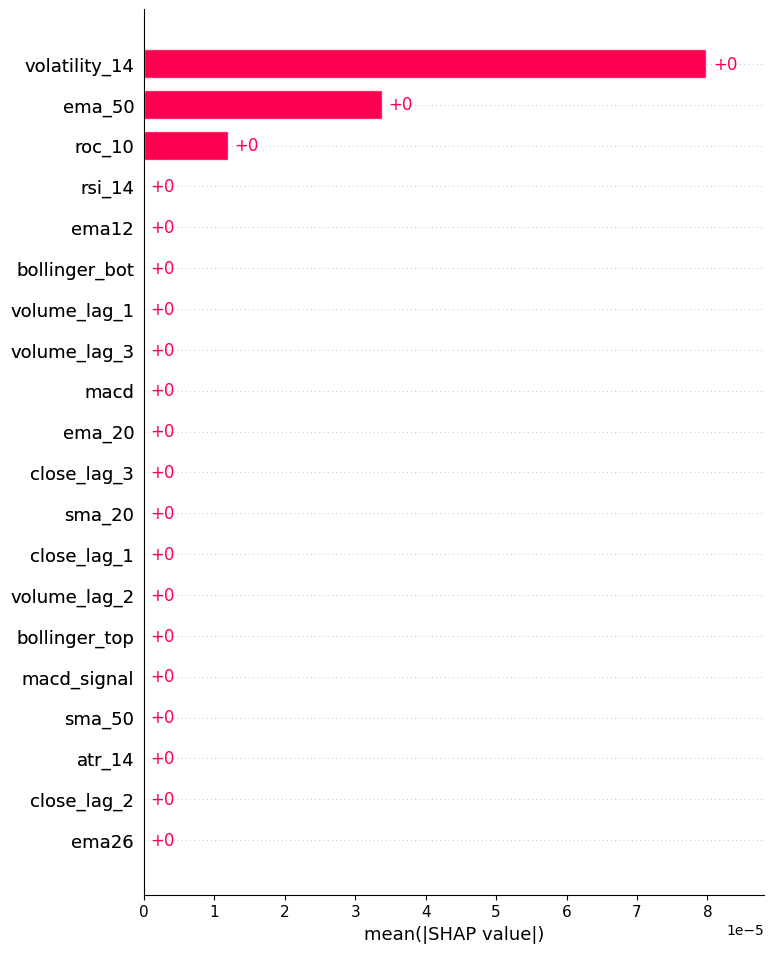

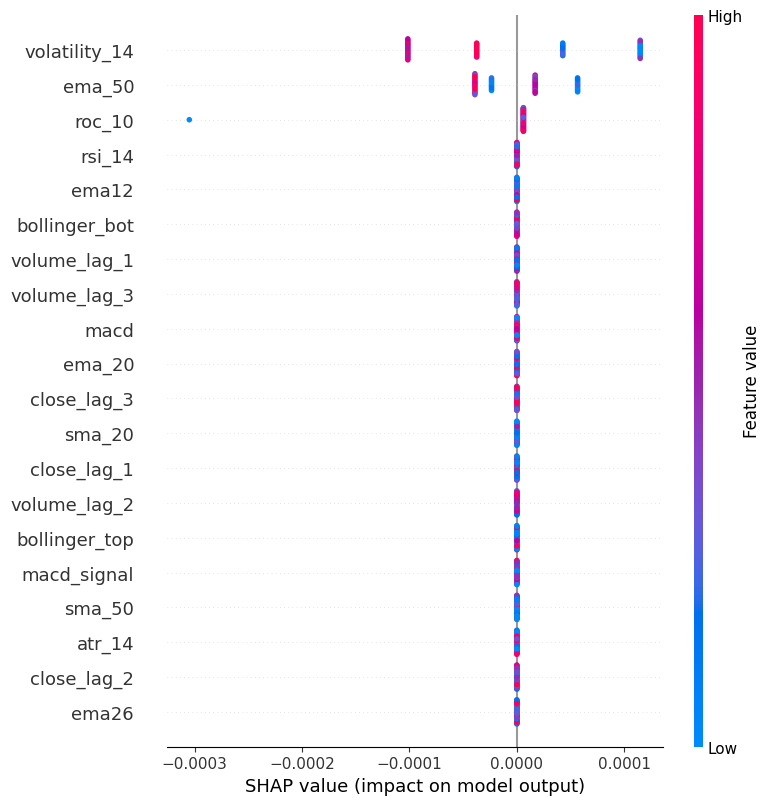

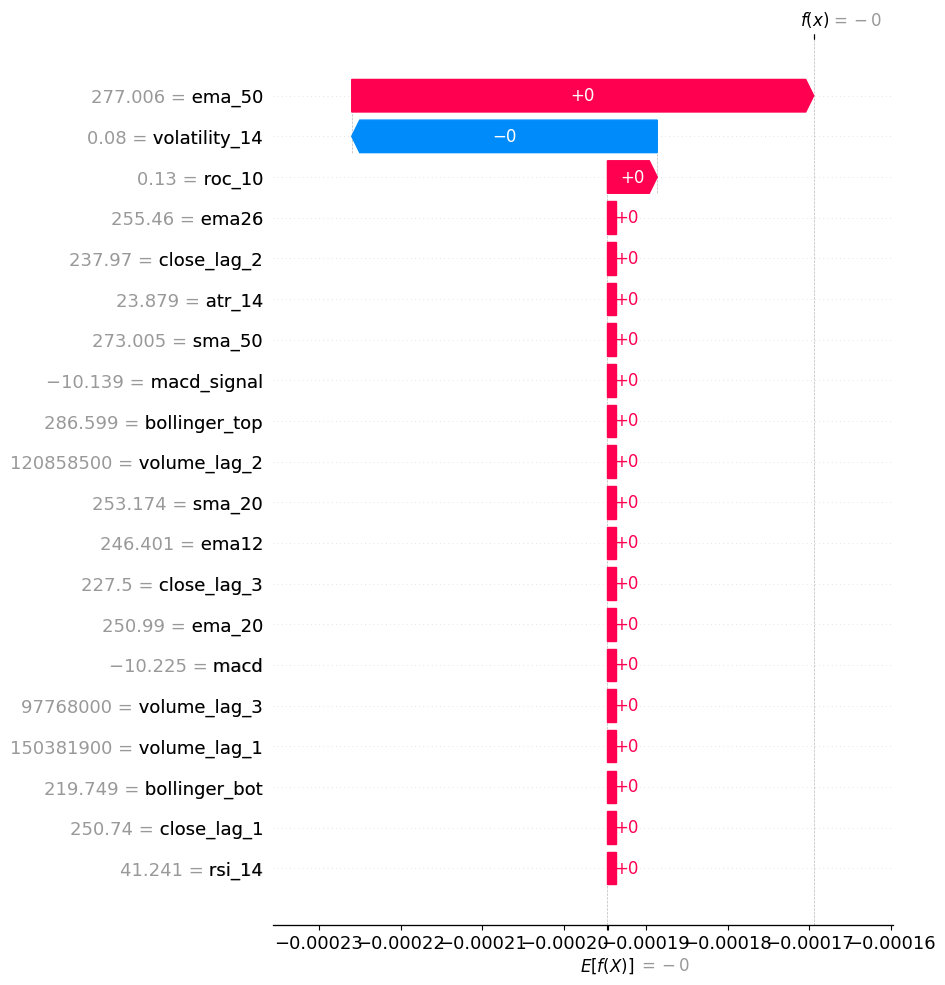

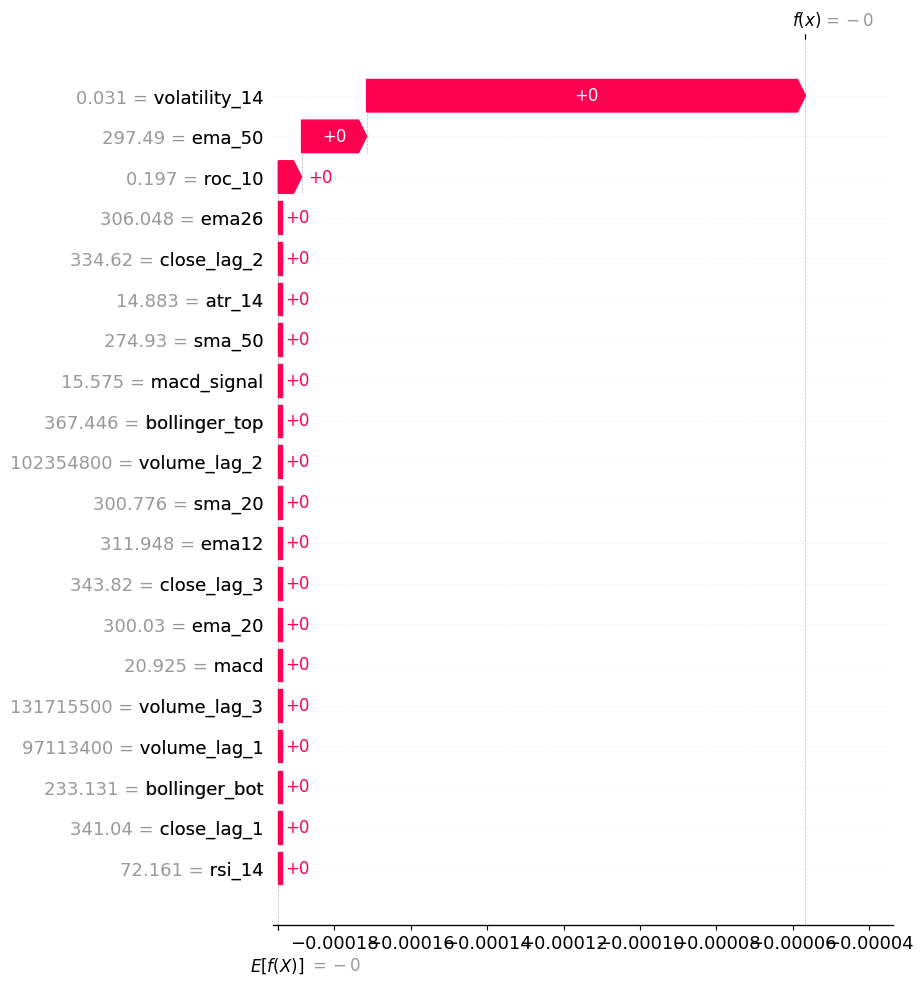

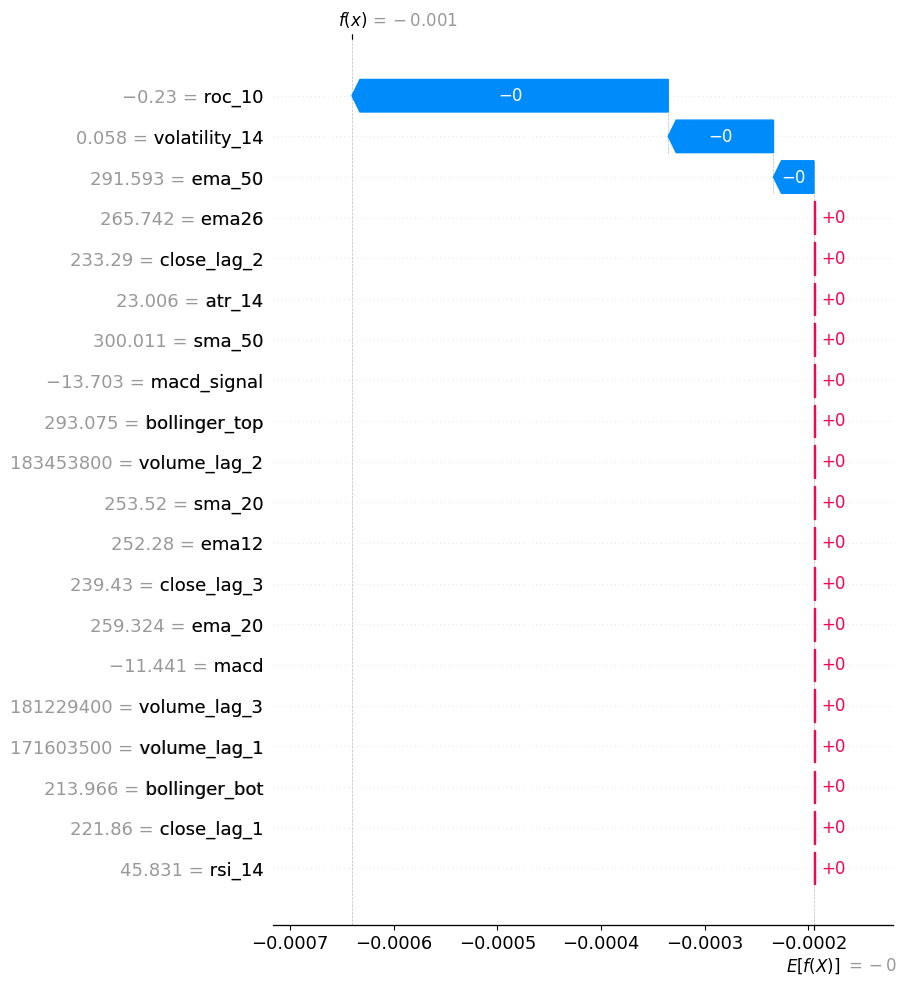

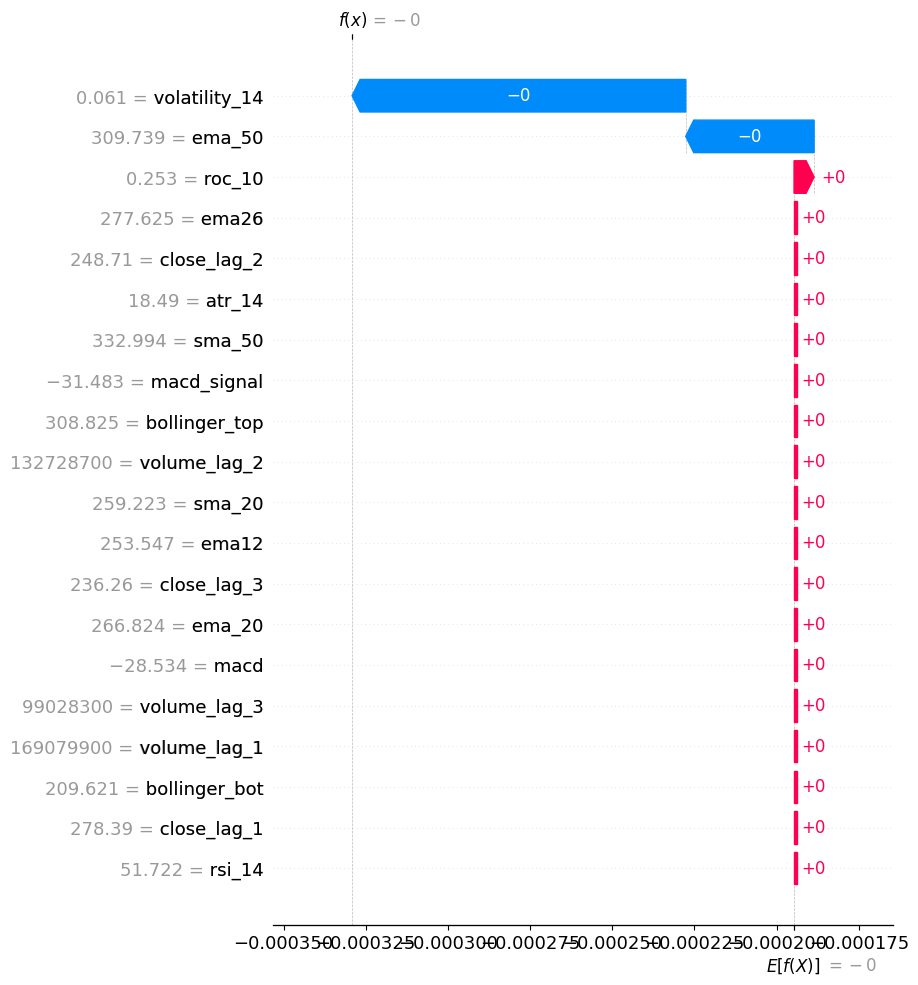

In [15]:
"""# model evaluation
metrics = ["mse", "mae"]

eval_test = ModelEvaluation(data={
    'y_true': y_test,
    'y_pred': model_handler.predict(X_test_tr)},
    metrics=metrics)
eval_pred = ModelEvaluation(data={
    'y_true': y_pred,
    'y_pred': y_scores},
    metrics=metrics)

print(eval_test.run())
print(eval_pred.run())"""

pipeline_data = PipelineData(
    X_train=X_train_tr,
    X_test=X_test_tr,
    X_pred=X_pred_tr,
    y_train=y_train,
    y_test=y_test,
    y_pred=y_pred,
    y_scores=y_scores,
)

result = Result(
    model_type="Regression",
    preprocessor=preprocessor,
    model_handler=model_handler,
    result_label = "pipeline",
    #model_evaluation={
    #    'test':eval_test.evaluation,
    #    'pred':eval_pred.evaluation},
    pipeline_data=pipeline_data
)



shapley_visualization = ShapleyVisualization(result)
shapley_visualization.bar_plot(max_display=25, show=True, clf=True)
shapley_visualization.beeswarm(max_display=25, show=True, clf=True)

n = 2
indices = shapley_visualization.get_head_tail_indices(n)

#loop for index towards positive
for i in range(n):
    shapley_visualization.waterfall_plot(indices[0][i], max_display=20, show=True, clf=True)
#loop for index towards negative
for i in range(n):
    shapley_visualization.waterfall_plot(indices[1][i], max_display=20, show=True, clf=True)

In [16]:
strategy_params = {"buy_threshold": 0.0005, "sell_threshold": -0.0007}
df_report, df_trades = BacktestRunner.run_backtest(prediction_dataset, ticker, prediction_start_date, prediction_end_date,
                            strategy=MLRegressionStrategy, strategy_params=strategy_params, cash=500)

Buy order executed at 2025-03-27 00:00:00 272.4800109863281
Sell order executed at 2025-04-10 00:00:00 260.0
Trade closed:
  Entry Time: 2025-03-27 00:00:00
  Exit Time: 2025-04-10 00:00:00
  Entry Price: 272.48
  Exit Price: 260.00
  Trade Size: 0
  PnL: -12.48
Buy order executed at 2025-04-11 00:00:00 251.83999633789062


In [17]:
df_trades

,entry_time,exit_time,entry_price,exit_price,pnl,size
0,2025-03-27,2025-04-10,272.48,260.00,-12.48,0


In [18]:
df_report

,Stock Ticker,Start Date,End Date,Initial Portfolio Value,Final Portfolio Value,Total Return (%),Annualized Return (%),Max Drawdown (%),SQN,Total Trades,Sharpe Ratio,ROI (%)
0,TSLA,2025-01-01,2025-06-02,500,593.33,17.11,84.56,1194.10,0,2,None,18.67


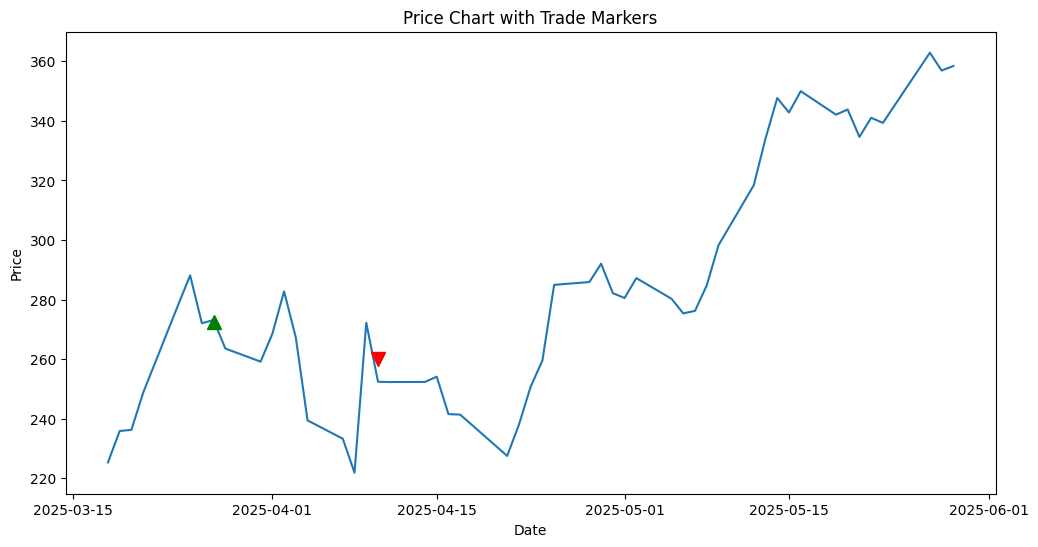

In [19]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_trades(price_data, df_trades):
    """
    Plots the price data with buy/sell markers.
    
    Args:
        price_data (pd.DataFrame): DataFrame with a DateTime index and a 'close' column.
        df_trades (pd.DataFrame): DataFrame with trade details including 'entry_time' and 'exit_time'.
    """
    plt.figure(figsize=(12,6))
    plt.plot(price_data.index, price_data['close'], label='Close Price')
    
    # Plot buy markers
    if not df_trades.empty:
        for _, trade in df_trades.iterrows():
            entry_time = pd.to_datetime(trade['entry_time'])
            exit_time = pd.to_datetime(trade['exit_time'])
            entry_price = trade['entry_price']
            exit_price = trade['exit_price']
            plt.plot(entry_time, entry_price, marker='^', color='g', markersize=10, label='Buy')
            plt.plot(exit_time, exit_price, marker='v', color='r', markersize=10, label='Sell')
    
    plt.xlabel("Date")
    plt.ylabel("Price")
    plt.title("Price Chart with Trade Markers")
    #plt.legend(loc='best')
    plt.show()

plot_trades(prediction_dataset, df_trades)


In [20]:
df_trades

,entry_time,exit_time,entry_price,exit_price,pnl,size
0,2025-03-27,2025-04-10,272.48,260.00,-12.48,0
